# 反向传播算法实战

我们将实现一个 `4` 层的全连接网络，来完成二分类任务。网络输入节点数为 `2`，隐藏 层的节点数设计为：`25、50`和`25`，输出层两个节点，分别表示属于类别 `1` 的概率和类别 `2` 的概率，如下图所示。这里并没有采用 `Softmax` 函数将网络输出概率值之和进行约束， 而是直接利用均方误差函数计算与 `One-hot` 编码的真实标签之间的误差，所有的网络激活 函数全部采用 `Sigmoid` 函数，这些设计都是为了能直接利用我们的梯度传播公式。 

![](https://i.postimg.cc/4dypfbvF/screenshot-24.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

### 1. 准备数据

In [2]:
X, y = datasets.make_moons(n_samples=1000, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X.shape, y.shape)

(1000, 2) (1000,)


In [3]:
def make_plot(X, y, plot_name):
    plt.figure(figsize=(12, 8))    
    plt.title(plot_name, fontsize=30)     
    plt.scatter(X[y==0, 0], X[y==0, 1])
    plt.scatter(X[y==1, 0], X[y==1, 1])

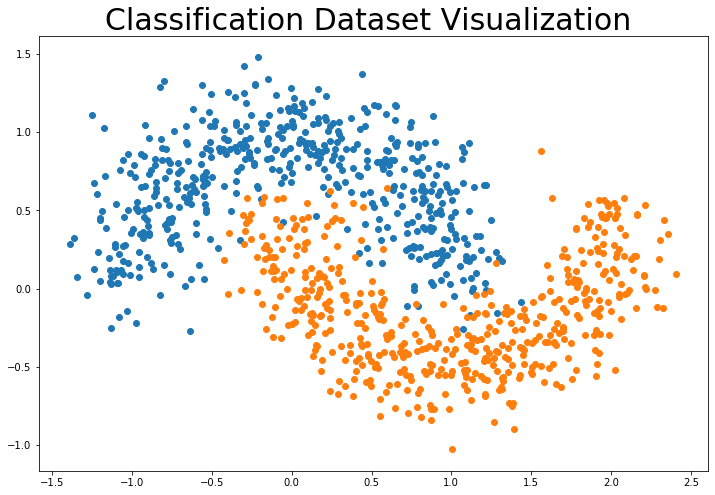

In [4]:
make_plot(X, y, "Classification Dataset Visualization ") 

### 2. 网络层
- 通过新建类 `Layer` 实现一个网络层，需要传入网络层的输入节点数、输出节点数、激 活函数类型等参数
- 权值 `weights` 和偏置张量 `bias` 在初始化时根据输入、输出节点数自动 生成并初始化

In [5]:
class Layer:
    # 全链接网络层
    def __init__(self, n_input, n_output, activation=None, weights=None, bias=None):
        """
        :param int n_input: 输入节点数 
        :param int n_output: 输出节点数         
        :param str activation: 激活函数类型         
        :param weights: 权值张量，默认类内部生成         
        :param bias: 偏置，默认类内部生成 
        """
        self.weights = weights if weights is not None else np.random.randn(n_input, n_output) * np.sqrt(1 / n_output) 
        self.bias = bias if bias is not None else np.random.rand(n_output) * 0.1
        self.activation = activation # 激活函数类型，如’sigmoid’         
        self.activation_output = None # 激活函数的输出值 o         
        self.error = None  # 用于计算当前层的 delta 变量的中间变量 
        self.delta = None  # 记录当前层的 delta 变量，用于计算梯度 
    
    def activate(self, X):
        # 前向计算函数
        r = np.dot(X, self.weights) + self.bias # X@W + b
        # 通过激活函数，得到全连接层的输出 o (activation_output)      
        self.activation_output = self._apply_activation(r) 
        return self.activation_output
    
    def _apply_activation(self, r): # 计算激活函数的输出
        if self.activation is None:
            return r # 无激活函数，直接返回
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        elif self.activation == 'tanh':
            return np.tanh(r)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        
        return r
    
    def apply_activation_derivative(self, r):
        # 计算激活函数的导数
        # 无激活函数， 导数为 1
        if self.activation is None:
            return np.ones_like(r)
        # ReLU 函数的导数
        elif self.activation == 'relu':             
            grad = np.array(r, copy=True)             
            grad[r > 0] = 1.             
            grad[r <= 0] = 0.             
            return grad
        # tanh 函数的导数实现         
        elif self.activation == 'tanh':             
            return 1 - r ** 2 
        # Sigmoid 函数的导数实现         
        elif self.activation == 'sigmoid': 
            return r * (1 - r)
        return r

### 3. 网络模型
- 创建单层网络类后，我们实现网络模型的 `NeuralNetwork` 类
- 它内部维护各层的网络 层 `Layer` 类对象，可以通过 `add_layer` 函数追加网络层，
- 实现创建不同结构的网络模型目 的。

In [6]:
y_test.flatten().shape

(300,)

In [7]:
class NeuralNetwork:
    def __init__(self):
        self._layers = [] # 网络层对象列表
    
    def add_layer(self, layer):
        self._layers.append(layer)
    
    def feed_forward(self, X):
        # 前向传播（求导）
        for layer in self._layers:
            X = layer.activate(X)
        return X
    
    def backpropagation(self, X, y, learning_rate):
        # 反向传播算法实现
        # 向前计算，得到最终输出值
        output = self.feed_forward(X)
        for i in reversed(range(len(self._layers))): # 反向循环
            layer = self._layers[i]
            if layer == self._layers[-1]: # 如果是输出层
                layer.error = y - output
                # 计算最后一层的 delta，参考输出层的梯度公式
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else: # 如果是隐藏层
                next_layer = self._layers[i + 1]
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error*layer.apply_activation_derivative(layer.activation_output)
        
        # 循环更新权值
        for i in range(len(self._layers)):
            layer = self._layers[i]
            # o_i 为上一网络层的输出
            o_i = np.atleast_2d(X if i == 0 else self._layers[i - 1].activation_output)
            # 梯度下降算法，delta 是公式中的负数，故这里用加号 
            layer.weights += layer.delta * o_i.T * learning_rate 
    
    def train(self, X_train, X_test, y_train, y_test, learning_rate, max_epochs):
        # 网络训练函数
        # one-hot 编码
        y_onehot = np.zeros((y_train.shape[0], 2)) 
        y_onehot[np.arange(y_train.shape[0]), y_train] = 1
        mses = [] 
        for i in range(max_epochs):  # 训练 100 个 epoch             
            for j in range(len(X_train)):  # 一次训练一个样本                 
                self.backpropagation(X_train[j], y_onehot[j], learning_rate)             
                if i % 10 == 0: 
                    # 打印出 MSE Loss                 
                    mse = np.mean(np.square(y_onehot - self.feed_forward(X_train)))                 
                    mses.append(mse)                 
                    print('Epoch: #%s, MSE: %f, Accuracy: %.2f%%' % 
                          (i, float(mse), self.accuracy(self.predict(X_test), y_test.flatten()) * 100)) 

        return mses
    
    def accuracy(self, y_predict, y_test): # 计算准确度
        return np.sum(y_predict == y_test) / len(y_test)
    
    def predict(self, X_predict):
        y_predict = self.feed_forward(X_predict) # 此时的 y_predict 形状是 [600 * 2]，第二个维度表示两个输出的概率
        y_predict = np.argmax(y_predict, axis=1)
        return y_predict        

### 4. 网络训练

In [8]:
nn = NeuralNetwork() # 实例化网络类 
nn.add_layer(Layer(2, 25, 'sigmoid'))  # 隐藏层 1, 2=>25 
nn.add_layer(Layer(25, 50, 'sigmoid')) # 隐藏层 2, 25=>50 
nn.add_layer(Layer(50, 25, 'sigmoid')) # 隐藏层 3, 50=>25 
nn.add_layer(Layer(25, 2, 'sigmoid'))  # 输出层, 25=>2 

In [9]:
nn.train(X_train, X_test, y_train, y_test, learning_rate=0.01, max_epochs=50)

Epoch: #0, MSE: 0.351275, Accuracy: 48.33%
Epoch: #0, MSE: 0.351756, Accuracy: 48.33%
Epoch: #0, MSE: 0.350259, Accuracy: 48.33%
Epoch: #0, MSE: 0.350742, Accuracy: 48.33%
Epoch: #0, MSE: 0.349257, Accuracy: 48.33%
Epoch: #0, MSE: 0.347767, Accuracy: 48.33%
Epoch: #0, MSE: 0.346289, Accuracy: 48.33%
Epoch: #0, MSE: 0.344834, Accuracy: 48.33%
Epoch: #0, MSE: 0.345339, Accuracy: 48.33%
Epoch: #0, MSE: 0.345843, Accuracy: 48.33%
Epoch: #0, MSE: 0.346348, Accuracy: 48.33%
Epoch: #0, MSE: 0.346850, Accuracy: 48.33%
Epoch: #0, MSE: 0.347350, Accuracy: 48.33%
Epoch: #0, MSE: 0.347847, Accuracy: 48.33%
Epoch: #0, MSE: 0.348339, Accuracy: 48.33%
Epoch: #0, MSE: 0.346835, Accuracy: 48.33%
Epoch: #0, MSE: 0.347333, Accuracy: 48.33%
Epoch: #0, MSE: 0.345837, Accuracy: 48.33%
Epoch: #0, MSE: 0.346339, Accuracy: 48.33%
Epoch: #0, MSE: 0.344846, Accuracy: 48.33%
Epoch: #0, MSE: 0.345348, Accuracy: 48.33%
Epoch: #0, MSE: 0.343852, Accuracy: 48.33%
Epoch: #0, MSE: 0.342367, Accuracy: 48.33%
Epoch: #0, 

Epoch: #0, MSE: 0.264806, Accuracy: 48.33%
Epoch: #0, MSE: 0.265407, Accuracy: 48.33%
Epoch: #0, MSE: 0.264248, Accuracy: 48.33%
Epoch: #0, MSE: 0.263142, Accuracy: 48.33%
Epoch: #0, MSE: 0.263721, Accuracy: 48.33%
Epoch: #0, MSE: 0.262632, Accuracy: 48.33%
Epoch: #0, MSE: 0.261599, Accuracy: 48.33%
Epoch: #0, MSE: 0.262142, Accuracy: 48.33%
Epoch: #0, MSE: 0.261123, Accuracy: 48.33%
Epoch: #0, MSE: 0.260162, Accuracy: 48.33%
Epoch: #0, MSE: 0.259264, Accuracy: 48.33%
Epoch: #0, MSE: 0.258423, Accuracy: 48.33%
Epoch: #0, MSE: 0.258866, Accuracy: 48.33%
Epoch: #0, MSE: 0.259327, Accuracy: 48.33%
Epoch: #0, MSE: 0.258456, Accuracy: 48.33%
Epoch: #0, MSE: 0.257646, Accuracy: 48.33%
Epoch: #0, MSE: 0.258074, Accuracy: 48.33%
Epoch: #0, MSE: 0.257279, Accuracy: 48.33%
Epoch: #0, MSE: 0.257712, Accuracy: 48.33%
Epoch: #0, MSE: 0.258167, Accuracy: 48.33%
Epoch: #0, MSE: 0.257334, Accuracy: 48.33%
Epoch: #0, MSE: 0.256568, Accuracy: 48.33%
Epoch: #0, MSE: 0.256997, Accuracy: 48.33%
Epoch: #0, 

Epoch: #0, MSE: 0.247784, Accuracy: 48.33%
Epoch: #0, MSE: 0.247821, Accuracy: 48.33%
Epoch: #0, MSE: 0.247913, Accuracy: 48.33%
Epoch: #0, MSE: 0.248059, Accuracy: 48.33%
Epoch: #0, MSE: 0.248252, Accuracy: 48.33%
Epoch: #0, MSE: 0.248492, Accuracy: 48.33%
Epoch: #0, MSE: 0.248212, Accuracy: 48.33%
Epoch: #0, MSE: 0.248446, Accuracy: 48.33%
Epoch: #0, MSE: 0.248174, Accuracy: 48.33%
Epoch: #0, MSE: 0.248402, Accuracy: 48.33%
Epoch: #0, MSE: 0.248678, Accuracy: 48.33%
Epoch: #0, MSE: 0.248998, Accuracy: 48.33%
Epoch: #0, MSE: 0.248617, Accuracy: 48.33%
Epoch: #0, MSE: 0.248306, Accuracy: 48.33%
Epoch: #0, MSE: 0.248064, Accuracy: 48.33%
Epoch: #0, MSE: 0.247885, Accuracy: 48.33%
Epoch: #0, MSE: 0.247771, Accuracy: 48.33%
Epoch: #0, MSE: 0.247719, Accuracy: 48.33%
Epoch: #0, MSE: 0.247727, Accuracy: 70.00%
Epoch: #0, MSE: 0.247796, Accuracy: 77.67%
Epoch: #0, MSE: 0.247920, Accuracy: 51.67%
Epoch: #0, MSE: 0.247786, Accuracy: 78.00%
Epoch: #0, MSE: 0.247713, Accuracy: 70.33%
Epoch: #0, 

Epoch: #0, MSE: 0.248500, Accuracy: 51.67%
Epoch: #0, MSE: 0.248858, Accuracy: 51.67%
Epoch: #0, MSE: 0.248460, Accuracy: 51.67%
Epoch: #0, MSE: 0.248817, Accuracy: 51.67%
Epoch: #0, MSE: 0.249213, Accuracy: 51.67%
Epoch: #0, MSE: 0.249659, Accuracy: 51.67%
Epoch: #0, MSE: 0.250136, Accuracy: 51.67%
Epoch: #0, MSE: 0.250653, Accuracy: 51.67%
Epoch: #0, MSE: 0.251205, Accuracy: 51.67%
Epoch: #0, MSE: 0.250524, Accuracy: 51.67%
Epoch: #0, MSE: 0.249913, Accuracy: 51.67%
Epoch: #0, MSE: 0.249371, Accuracy: 51.67%
Epoch: #0, MSE: 0.249831, Accuracy: 51.67%
Epoch: #0, MSE: 0.250334, Accuracy: 51.67%
Epoch: #0, MSE: 0.249743, Accuracy: 51.67%
Epoch: #0, MSE: 0.250228, Accuracy: 51.67%
Epoch: #0, MSE: 0.249648, Accuracy: 51.67%
Epoch: #0, MSE: 0.250134, Accuracy: 51.67%
Epoch: #0, MSE: 0.249566, Accuracy: 51.67%
Epoch: #0, MSE: 0.249066, Accuracy: 51.67%
Epoch: #0, MSE: 0.248633, Accuracy: 51.67%
Epoch: #0, MSE: 0.249011, Accuracy: 51.67%
Epoch: #0, MSE: 0.249435, Accuracy: 51.67%
Epoch: #0, 

Epoch: #10, MSE: 0.233292, Accuracy: 51.33%
Epoch: #10, MSE: 0.233712, Accuracy: 48.67%
Epoch: #10, MSE: 0.234112, Accuracy: 48.67%
Epoch: #10, MSE: 0.234617, Accuracy: 48.33%
Epoch: #10, MSE: 0.234039, Accuracy: 48.67%
Epoch: #10, MSE: 0.234521, Accuracy: 48.33%
Epoch: #10, MSE: 0.234988, Accuracy: 48.33%
Epoch: #10, MSE: 0.235549, Accuracy: 48.33%
Epoch: #10, MSE: 0.236084, Accuracy: 48.33%
Epoch: #10, MSE: 0.235327, Accuracy: 48.33%
Epoch: #10, MSE: 0.235850, Accuracy: 48.33%
Epoch: #10, MSE: 0.235102, Accuracy: 48.33%
Epoch: #10, MSE: 0.234458, Accuracy: 48.33%
Epoch: #10, MSE: 0.234907, Accuracy: 48.33%
Epoch: #10, MSE: 0.234263, Accuracy: 48.67%
Epoch: #10, MSE: 0.233723, Accuracy: 48.67%
Epoch: #10, MSE: 0.234132, Accuracy: 48.67%
Epoch: #10, MSE: 0.234621, Accuracy: 48.33%
Epoch: #10, MSE: 0.234039, Accuracy: 48.67%
Epoch: #10, MSE: 0.233519, Accuracy: 49.33%
Epoch: #10, MSE: 0.233074, Accuracy: 52.00%
Epoch: #10, MSE: 0.232719, Accuracy: 61.00%
Epoch: #10, MSE: 0.233012, Accur

Epoch: #10, MSE: 0.233093, Accuracy: 48.67%
Epoch: #10, MSE: 0.233543, Accuracy: 48.67%
Epoch: #10, MSE: 0.232947, Accuracy: 48.67%
Epoch: #10, MSE: 0.233389, Accuracy: 48.67%
Epoch: #10, MSE: 0.233903, Accuracy: 48.33%
Epoch: #10, MSE: 0.234396, Accuracy: 48.33%
Epoch: #10, MSE: 0.235038, Accuracy: 48.33%
Epoch: #10, MSE: 0.234287, Accuracy: 48.33%
Epoch: #10, MSE: 0.233630, Accuracy: 48.67%
Epoch: #10, MSE: 0.233036, Accuracy: 48.67%
Epoch: #10, MSE: 0.232538, Accuracy: 50.33%
Epoch: #10, MSE: 0.232937, Accuracy: 48.67%
Epoch: #10, MSE: 0.232433, Accuracy: 51.00%
Epoch: #10, MSE: 0.232019, Accuracy: 56.00%
Epoch: #10, MSE: 0.231683, Accuracy: 66.33%
Epoch: #10, MSE: 0.231956, Accuracy: 57.33%
Epoch: #10, MSE: 0.231628, Accuracy: 68.00%
Epoch: #10, MSE: 0.231368, Accuracy: 74.67%
Epoch: #10, MSE: 0.231565, Accuracy: 69.33%
Epoch: #10, MSE: 0.231810, Accuracy: 60.33%
Epoch: #10, MSE: 0.232116, Accuracy: 53.33%
Epoch: #10, MSE: 0.231749, Accuracy: 61.00%
Epoch: #10, MSE: 0.231445, Accur

Epoch: #10, MSE: 0.232757, Accuracy: 53.33%
Epoch: #10, MSE: 0.233252, Accuracy: 52.33%
Epoch: #10, MSE: 0.233795, Accuracy: 51.67%
Epoch: #10, MSE: 0.234469, Accuracy: 51.67%
Epoch: #10, MSE: 0.233678, Accuracy: 51.67%
Epoch: #10, MSE: 0.232976, Accuracy: 52.67%
Epoch: #10, MSE: 0.233509, Accuracy: 52.00%
Epoch: #10, MSE: 0.234093, Accuracy: 51.67%
Epoch: #10, MSE: 0.233342, Accuracy: 52.33%
Epoch: #10, MSE: 0.232656, Accuracy: 53.33%
Epoch: #10, MSE: 0.233208, Accuracy: 52.33%
Epoch: #10, MSE: 0.232545, Accuracy: 54.00%
Epoch: #10, MSE: 0.233064, Accuracy: 52.33%
Epoch: #10, MSE: 0.233613, Accuracy: 51.67%
Epoch: #10, MSE: 0.232883, Accuracy: 52.67%
Epoch: #10, MSE: 0.232239, Accuracy: 55.33%
Epoch: #10, MSE: 0.232744, Accuracy: 53.33%
Epoch: #10, MSE: 0.232128, Accuracy: 57.00%
Epoch: #10, MSE: 0.232595, Accuracy: 53.33%
Epoch: #10, MSE: 0.231976, Accuracy: 59.33%
Epoch: #10, MSE: 0.231455, Accuracy: 69.00%
Epoch: #10, MSE: 0.231886, Accuracy: 60.67%
Epoch: #10, MSE: 0.232398, Accur

Epoch: #20, MSE: 0.145404, Accuracy: 80.00%
Epoch: #20, MSE: 0.145449, Accuracy: 79.00%
Epoch: #20, MSE: 0.145491, Accuracy: 79.67%
Epoch: #20, MSE: 0.145418, Accuracy: 79.00%
Epoch: #20, MSE: 0.145345, Accuracy: 79.00%
Epoch: #20, MSE: 0.145354, Accuracy: 79.00%
Epoch: #20, MSE: 0.145325, Accuracy: 80.33%
Epoch: #20, MSE: 0.145478, Accuracy: 80.67%
Epoch: #20, MSE: 0.145370, Accuracy: 80.33%
Epoch: #20, MSE: 0.145523, Accuracy: 80.67%
Epoch: #20, MSE: 0.145607, Accuracy: 80.33%
Epoch: #20, MSE: 0.145461, Accuracy: 80.67%
Epoch: #20, MSE: 0.145346, Accuracy: 81.00%
Epoch: #20, MSE: 0.145372, Accuracy: 80.67%
Epoch: #20, MSE: 0.145458, Accuracy: 80.33%
Epoch: #20, MSE: 0.145663, Accuracy: 80.33%
Epoch: #20, MSE: 0.145550, Accuracy: 80.00%
Epoch: #20, MSE: 0.145325, Accuracy: 81.00%
Epoch: #20, MSE: 0.145246, Accuracy: 80.67%
Epoch: #20, MSE: 0.145304, Accuracy: 80.67%
Epoch: #20, MSE: 0.145341, Accuracy: 80.33%
Epoch: #20, MSE: 0.145519, Accuracy: 80.33%
Epoch: #20, MSE: 0.145712, Accur

Epoch: #20, MSE: 0.143731, Accuracy: 80.00%
Epoch: #20, MSE: 0.143115, Accuracy: 80.33%
Epoch: #20, MSE: 0.142843, Accuracy: 80.00%
Epoch: #20, MSE: 0.143165, Accuracy: 80.67%
Epoch: #20, MSE: 0.143858, Accuracy: 79.67%
Epoch: #20, MSE: 0.144115, Accuracy: 79.33%
Epoch: #20, MSE: 0.144255, Accuracy: 79.33%
Epoch: #20, MSE: 0.143840, Accuracy: 79.67%
Epoch: #20, MSE: 0.144025, Accuracy: 79.67%
Epoch: #20, MSE: 0.144433, Accuracy: 79.00%
Epoch: #20, MSE: 0.144614, Accuracy: 78.67%
Epoch: #20, MSE: 0.144182, Accuracy: 79.33%
Epoch: #20, MSE: 0.143840, Accuracy: 79.67%
Epoch: #20, MSE: 0.143998, Accuracy: 79.33%
Epoch: #20, MSE: 0.144858, Accuracy: 79.00%
Epoch: #20, MSE: 0.144435, Accuracy: 79.00%
Epoch: #20, MSE: 0.144063, Accuracy: 79.33%
Epoch: #20, MSE: 0.144323, Accuracy: 79.00%
Epoch: #20, MSE: 0.144020, Accuracy: 79.33%
Epoch: #20, MSE: 0.144173, Accuracy: 79.33%
Epoch: #20, MSE: 0.144471, Accuracy: 79.00%
Epoch: #20, MSE: 0.143732, Accuracy: 79.67%
Epoch: #20, MSE: 0.144036, Accur

Epoch: #20, MSE: 0.139563, Accuracy: 79.67%
Epoch: #20, MSE: 0.139478, Accuracy: 80.00%
Epoch: #20, MSE: 0.139577, Accuracy: 79.67%
Epoch: #20, MSE: 0.139610, Accuracy: 80.33%
Epoch: #20, MSE: 0.139962, Accuracy: 80.67%
Epoch: #20, MSE: 0.140070, Accuracy: 81.00%
Epoch: #20, MSE: 0.140205, Accuracy: 81.00%
Epoch: #20, MSE: 0.140334, Accuracy: 80.67%
Epoch: #20, MSE: 0.139904, Accuracy: 80.67%
Epoch: #20, MSE: 0.139637, Accuracy: 79.67%
Epoch: #20, MSE: 0.139540, Accuracy: 80.00%
Epoch: #20, MSE: 0.139550, Accuracy: 79.00%
Epoch: #20, MSE: 0.139596, Accuracy: 79.67%
Epoch: #20, MSE: 0.139539, Accuracy: 79.33%
Epoch: #20, MSE: 0.139648, Accuracy: 80.33%
Epoch: #20, MSE: 0.140014, Accuracy: 80.67%
Epoch: #20, MSE: 0.139791, Accuracy: 80.67%
Epoch: #20, MSE: 0.139615, Accuracy: 80.33%
Epoch: #20, MSE: 0.139543, Accuracy: 79.67%
Epoch: #20, MSE: 0.139567, Accuracy: 80.33%
Epoch: #20, MSE: 0.139606, Accuracy: 80.33%
Epoch: #20, MSE: 0.139956, Accuracy: 80.67%
Epoch: #20, MSE: 0.140029, Accur

Epoch: #30, MSE: 0.101762, Accuracy: 84.33%
Epoch: #30, MSE: 0.101751, Accuracy: 84.33%
Epoch: #30, MSE: 0.101749, Accuracy: 84.33%
Epoch: #30, MSE: 0.101747, Accuracy: 84.33%
Epoch: #30, MSE: 0.101752, Accuracy: 84.33%
Epoch: #30, MSE: 0.101736, Accuracy: 84.67%
Epoch: #30, MSE: 0.101733, Accuracy: 84.33%
Epoch: #30, MSE: 0.101718, Accuracy: 84.33%
Epoch: #30, MSE: 0.101719, Accuracy: 84.33%
Epoch: #30, MSE: 0.101719, Accuracy: 84.33%
Epoch: #30, MSE: 0.101722, Accuracy: 84.33%
Epoch: #30, MSE: 0.101753, Accuracy: 84.00%
Epoch: #30, MSE: 0.101711, Accuracy: 84.33%
Epoch: #30, MSE: 0.101699, Accuracy: 84.33%
Epoch: #30, MSE: 0.101707, Accuracy: 84.33%
Epoch: #30, MSE: 0.101712, Accuracy: 84.33%
Epoch: #30, MSE: 0.101702, Accuracy: 84.33%
Epoch: #30, MSE: 0.101691, Accuracy: 84.33%
Epoch: #30, MSE: 0.101688, Accuracy: 84.33%
Epoch: #30, MSE: 0.101684, Accuracy: 84.33%
Epoch: #30, MSE: 0.101685, Accuracy: 84.33%
Epoch: #30, MSE: 0.101687, Accuracy: 84.33%
Epoch: #30, MSE: 0.101680, Accur

Epoch: #30, MSE: 0.101142, Accuracy: 84.00%
Epoch: #30, MSE: 0.101137, Accuracy: 84.00%
Epoch: #30, MSE: 0.101143, Accuracy: 84.00%
Epoch: #30, MSE: 0.101173, Accuracy: 84.00%
Epoch: #30, MSE: 0.101163, Accuracy: 84.00%
Epoch: #30, MSE: 0.101172, Accuracy: 84.00%
Epoch: #30, MSE: 0.101155, Accuracy: 84.00%
Epoch: #30, MSE: 0.101161, Accuracy: 84.00%
Epoch: #30, MSE: 0.101143, Accuracy: 84.00%
Epoch: #30, MSE: 0.101239, Accuracy: 83.67%
Epoch: #30, MSE: 0.101222, Accuracy: 83.67%
Epoch: #30, MSE: 0.101182, Accuracy: 84.00%
Epoch: #30, MSE: 0.101451, Accuracy: 83.00%
Epoch: #30, MSE: 0.101481, Accuracy: 83.33%
Epoch: #30, MSE: 0.101603, Accuracy: 83.00%
Epoch: #30, MSE: 0.101518, Accuracy: 83.33%
Epoch: #30, MSE: 0.101555, Accuracy: 83.33%
Epoch: #30, MSE: 0.101507, Accuracy: 83.33%
Epoch: #30, MSE: 0.101579, Accuracy: 83.00%
Epoch: #30, MSE: 0.101644, Accuracy: 83.00%
Epoch: #30, MSE: 0.101356, Accuracy: 83.00%
Epoch: #30, MSE: 0.101518, Accuracy: 83.33%
Epoch: #30, MSE: 0.101479, Accur

Epoch: #30, MSE: 0.101047, Accuracy: 84.33%
Epoch: #30, MSE: 0.100965, Accuracy: 84.33%
Epoch: #30, MSE: 0.100904, Accuracy: 84.67%
Epoch: #30, MSE: 0.100988, Accuracy: 84.33%
Epoch: #30, MSE: 0.101094, Accuracy: 84.33%
Epoch: #30, MSE: 0.101293, Accuracy: 84.33%
Epoch: #30, MSE: 0.100986, Accuracy: 84.33%
Epoch: #30, MSE: 0.101009, Accuracy: 84.33%
Epoch: #30, MSE: 0.100972, Accuracy: 84.33%
Epoch: #30, MSE: 0.101102, Accuracy: 84.33%
Epoch: #30, MSE: 0.101150, Accuracy: 84.33%
Epoch: #30, MSE: 0.100853, Accuracy: 84.67%
Epoch: #30, MSE: 0.101013, Accuracy: 84.33%
Epoch: #30, MSE: 0.100917, Accuracy: 84.33%
Epoch: #30, MSE: 0.100935, Accuracy: 84.33%
Epoch: #30, MSE: 0.101381, Accuracy: 84.33%
Epoch: #30, MSE: 0.101399, Accuracy: 84.33%
Epoch: #30, MSE: 0.101420, Accuracy: 84.33%
Epoch: #30, MSE: 0.101443, Accuracy: 84.33%
Epoch: #30, MSE: 0.101418, Accuracy: 84.33%
Epoch: #30, MSE: 0.101723, Accuracy: 83.67%
Epoch: #30, MSE: 0.102434, Accuracy: 83.67%
Epoch: #30, MSE: 0.102522, Accur

Epoch: #40, MSE: 0.090778, Accuracy: 85.00%
Epoch: #40, MSE: 0.090797, Accuracy: 85.00%
Epoch: #40, MSE: 0.090804, Accuracy: 85.00%
Epoch: #40, MSE: 0.090764, Accuracy: 85.00%
Epoch: #40, MSE: 0.090772, Accuracy: 85.00%
Epoch: #40, MSE: 0.090401, Accuracy: 85.00%
Epoch: #40, MSE: 0.090127, Accuracy: 85.00%
Epoch: #40, MSE: 0.090133, Accuracy: 85.00%
Epoch: #40, MSE: 0.090337, Accuracy: 85.00%
Epoch: #40, MSE: 0.090326, Accuracy: 85.00%
Epoch: #40, MSE: 0.090299, Accuracy: 85.00%
Epoch: #40, MSE: 0.089923, Accuracy: 85.33%
Epoch: #40, MSE: 0.089927, Accuracy: 85.33%
Epoch: #40, MSE: 0.089903, Accuracy: 85.33%
Epoch: #40, MSE: 0.089880, Accuracy: 85.33%
Epoch: #40, MSE: 0.089850, Accuracy: 85.33%
Epoch: #40, MSE: 0.089814, Accuracy: 85.33%
Epoch: #40, MSE: 0.089672, Accuracy: 85.67%
Epoch: #40, MSE: 0.089671, Accuracy: 85.67%
Epoch: #40, MSE: 0.089668, Accuracy: 85.67%
Epoch: #40, MSE: 0.089667, Accuracy: 85.67%
Epoch: #40, MSE: 0.089722, Accuracy: 85.00%
Epoch: #40, MSE: 0.089820, Accur

Epoch: #40, MSE: 0.089522, Accuracy: 85.00%
Epoch: #40, MSE: 0.089473, Accuracy: 85.67%
Epoch: #40, MSE: 0.089523, Accuracy: 85.67%
Epoch: #40, MSE: 0.089519, Accuracy: 85.67%
Epoch: #40, MSE: 0.089521, Accuracy: 85.67%
Epoch: #40, MSE: 0.089659, Accuracy: 85.67%
Epoch: #40, MSE: 0.089665, Accuracy: 85.67%
Epoch: #40, MSE: 0.089666, Accuracy: 85.67%
Epoch: #40, MSE: 0.089646, Accuracy: 85.67%
Epoch: #40, MSE: 0.089628, Accuracy: 85.67%
Epoch: #40, MSE: 0.089497, Accuracy: 85.67%
Epoch: #40, MSE: 0.089498, Accuracy: 85.67%
Epoch: #40, MSE: 0.089499, Accuracy: 85.67%
Epoch: #40, MSE: 0.089505, Accuracy: 85.67%
Epoch: #40, MSE: 0.089506, Accuracy: 85.67%
Epoch: #40, MSE: 0.089554, Accuracy: 85.67%
Epoch: #40, MSE: 0.089470, Accuracy: 85.67%
Epoch: #40, MSE: 0.089469, Accuracy: 85.67%
Epoch: #40, MSE: 0.089469, Accuracy: 85.67%
Epoch: #40, MSE: 0.089468, Accuracy: 85.67%
Epoch: #40, MSE: 0.089468, Accuracy: 85.67%
Epoch: #40, MSE: 0.089468, Accuracy: 85.67%
Epoch: #40, MSE: 0.089468, Accur

Epoch: #40, MSE: 0.089321, Accuracy: 85.67%
Epoch: #40, MSE: 0.089320, Accuracy: 85.67%
Epoch: #40, MSE: 0.089318, Accuracy: 85.67%
Epoch: #40, MSE: 0.089379, Accuracy: 85.00%
Epoch: #40, MSE: 0.089383, Accuracy: 85.00%
Epoch: #40, MSE: 0.089458, Accuracy: 84.67%
Epoch: #40, MSE: 0.089684, Accuracy: 84.67%
Epoch: #40, MSE: 0.089716, Accuracy: 84.67%
Epoch: #40, MSE: 0.089745, Accuracy: 84.67%
Epoch: #40, MSE: 0.089762, Accuracy: 84.67%
Epoch: #40, MSE: 0.089906, Accuracy: 84.67%
Epoch: #40, MSE: 0.089946, Accuracy: 85.00%
Epoch: #40, MSE: 0.089934, Accuracy: 84.67%
Epoch: #40, MSE: 0.089893, Accuracy: 84.67%
Epoch: #40, MSE: 0.089827, Accuracy: 84.67%
Epoch: #40, MSE: 0.089845, Accuracy: 84.67%
Epoch: #40, MSE: 0.089853, Accuracy: 84.67%
Epoch: #40, MSE: 0.089862, Accuracy: 84.67%
Epoch: #40, MSE: 0.089902, Accuracy: 84.67%
Epoch: #40, MSE: 0.089928, Accuracy: 84.67%
Epoch: #40, MSE: 0.089922, Accuracy: 84.67%
Epoch: #40, MSE: 0.089944, Accuracy: 85.00%
Epoch: #40, MSE: 0.089932, Accur

Epoch: #40, MSE: 0.091040, Accuracy: 85.67%
Epoch: #40, MSE: 0.090638, Accuracy: 85.67%
Epoch: #40, MSE: 0.090818, Accuracy: 85.67%
Epoch: #40, MSE: 0.090805, Accuracy: 85.67%
Epoch: #40, MSE: 0.090742, Accuracy: 85.67%
Epoch: #40, MSE: 0.090129, Accuracy: 84.67%
Epoch: #40, MSE: 0.090143, Accuracy: 84.67%
Epoch: #40, MSE: 0.090589, Accuracy: 85.67%
Epoch: #40, MSE: 0.090214, Accuracy: 84.67%
Epoch: #40, MSE: 0.090277, Accuracy: 84.67%
Epoch: #40, MSE: 0.090243, Accuracy: 84.67%
Epoch: #40, MSE: 0.089885, Accuracy: 85.00%
Epoch: #40, MSE: 0.089506, Accuracy: 84.67%
Epoch: #40, MSE: 0.089501, Accuracy: 84.67%
Epoch: #40, MSE: 0.089553, Accuracy: 84.67%
Epoch: #40, MSE: 0.089567, Accuracy: 84.67%
Epoch: #40, MSE: 0.089541, Accuracy: 84.67%
Epoch: #40, MSE: 0.089570, Accuracy: 84.67%
Epoch: #40, MSE: 0.089700, Accuracy: 84.67%
Epoch: #40, MSE: 0.089715, Accuracy: 84.67%
Epoch: #40, MSE: 0.089692, Accuracy: 84.67%
Epoch: #40, MSE: 0.089683, Accuracy: 84.67%
Epoch: #40, MSE: 0.089368, Accur

[0.3512748467176577,
 0.3517562008555903,
 0.35025918364874,
 0.3507419466278671,
 0.3492566581760249,
 0.34776665562834863,
 0.3462887471377679,
 0.3448342223799072,
 0.34533878795151846,
 0.3458430729870291,
 0.3463483858349882,
 0.3468504272179717,
 0.34734962472743836,
 0.34784739281496824,
 0.3483390147480123,
 0.346835472935372,
 0.34733308407665564,
 0.34583651147957245,
 0.3463391150416807,
 0.34484588476247763,
 0.3453484093730793,
 0.34385246997838176,
 0.34236690541482445,
 0.3408918503365808,
 0.34140776803284717,
 0.34192377777123967,
 0.3424372918289404,
 0.34294931274920726,
 0.34345920938383867,
 0.34196264107594426,
 0.3424762357205839,
 0.3409833621188381,
 0.34150237610797135,
 0.342021030659129,
 0.3405136413190024,
 0.34103336115679195,
 0.3395261729699321,
 0.34005763249166626,
 0.3385605058972028,
 0.33909393479285377,
 0.3375918848284667,
 0.33811961213911335,
 0.3386446520584562,
 0.3391794922174369,
 0.339708254700886,
 0.34023086150397885,
 0.3407616302794286

In [11]:
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1] - axis[0])*100)).reshape(1, -1),
        np.linspace(axis[2], axis[3], int((axis[3] - axis[2])*100)).reshape(-1, 1)
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    
    y_predic = model.predict(X_new)
    zz = y_predic.reshape(x0.shape)
    
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A', '#FFF590', '#90CAF9'])
    
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)

c:\users\13773\tfdev\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  from ipykernel import kernelapp as app


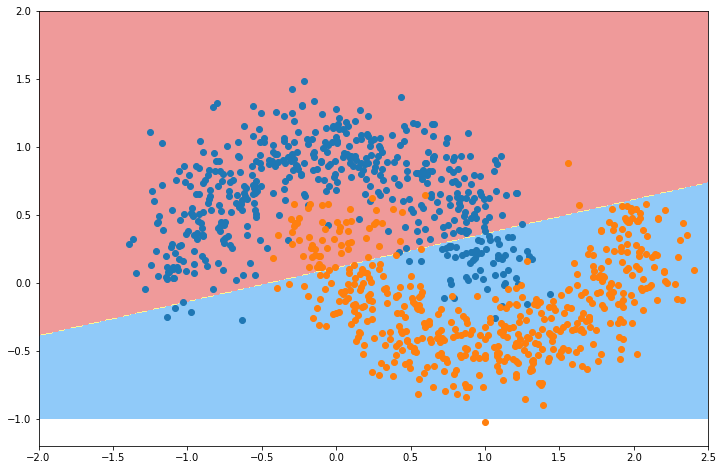

In [12]:
plt.figure(figsize=(12, 8))    
plot_decision_boundary(nn, [-2, 2.5, -1, 2])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

In [13]:
y_predict = nn.predict(X_test)

In [14]:
y_predict[:10]

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int64)

In [15]:
y_test[:10]

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int64)

In [16]:
nn.accuracy(y_predict, y_test.flatten())

0.86